In [1]:
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets
from torchvision import transforms

In [2]:
data_dir = '../data/gray_formatted/'
batch_size = 8
n_workers = 4
n_epochs = 500
lr = 0.001
img_dim = 64
display_delay = 500

In [3]:
def input_transform(img):
    img = np.array(img)[:, :, 0]
    target, outline = np.split(img, 2, axis=1)
    target = transforms.ToTensor()(target)
    outline = transforms.ToTensor()(outline)
    return outline, target

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=input_transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=n_workers)

def get_generator():
    data_iter = iter(dataloader)
    for (X, y), _ in data_iter:
        yield X, y

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # 1 x 64 x 64 input
        # Downscale
        self.ds1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.ds2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.ds3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.4))
        
        # Upscale
        self.us1 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            nn.ReLU())
        self.us2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.us3 = nn.Sequential(
            nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=2),
            nn.Upsample(scale_factor=2))
        
        self.detail = nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        # Downscale
        z1 = self.ds1(x)
        z2 = self.ds2(z1)
        z3 = self.ds3(z2)
        
        z4 = self.us1(z3) + z2
        z5 = self.us2(z4) + z1
        z6 = self.us3(z5) + x
        
        raw = self.detail(z6)
        
        out = torch.clamp(raw, 0, 1)
        
        return out

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 1 x 64 x 64 input
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Linear(16 * 2 * 2, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        z = self.layer1(x)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z).view(x.shape[0], -1)
        prob = self.layer5(z)
        
        return prob

In [16]:
def calc_loss(x, y, gen, disc):
    real_input = torch.stack((x, y), dim=1).squeeze()
    fake_input = torch.stack((x, gen(x)), dim=1).squeeze()
    
    real_prob = disc(real_input)
    fake_prob = disc(fake_input)
    
    gen_loss = -torch.log(fake_prob)
    gen_loss = torch.mean(gen_loss.view(-1))
    
    disc_loss = -torch.log(real_prob) - torch.log(1 - fake_prob)
    disc_loss = torch.mean(disc_loss.view(-1))
    
    return gen_loss, disc_loss

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.train()
discriminator.train()

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

gen_losses = []
disc_losses = []

for epoch in range(n_epochs):
    print(f'Starting epoch #{epoch+1}')
    
    data_gen = get_generator()
    for step, (X, y) in enumerate(data_gen):
        X = X.to(device)
        y = y.to(device)

        gen_optimizer.zero_grad()
        disc_optimizer.zero_grad()

        gen_loss, disc_loss = calc_loss(X, y, generator, discriminator)
        
        gen_losses.append(gen_loss.detach().numpy())
        disc_losses.append(disc_loss.detach().numpy())

        if step > 0 and step % display_delay == 0:
            print(f'Step #{step} | gen_loss: {np.mean(gen_losses[-display_delay:])} | disc_loss: {np.mean(disc_losses[-display_delay:])}')

        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()
        
        disc_loss.backward()
        disc_optimizer.step()
        
    print(f'Epoch #{epoch+1} | gen_loss: {np.mean(gen_losses[-step:])} | disc_loss: {np.mean(disc_losses[-step:])}')

Starting epoch #1
Step #20 | gen_loss: 0.4187631607055664 | disc_loss: 1.5160791873931885
Step #40 | gen_loss: 0.4442346692085266 | disc_loss: 1.4964098930358887
Step #60 | gen_loss: 0.42229461669921875 | disc_loss: 1.4952692985534668
Step #80 | gen_loss: 0.4498099386692047 | disc_loss: 1.3378188610076904
Step #100 | gen_loss: 0.6462296843528748 | disc_loss: 0.7722471356391907
Step #120 | gen_loss: 0.6998966336250305 | disc_loss: 0.696082592010498
Step #140 | gen_loss: 0.6756992340087891 | disc_loss: 0.716535747051239
Step #160 | gen_loss: 0.6752144694328308 | disc_loss: 0.7117530107498169
Step #180 | gen_loss: 0.695217490196228 | disc_loss: 0.6913856267929077
Step #200 | gen_loss: 0.6926531791687012 | disc_loss: 0.6937889456748962
Step #220 | gen_loss: 0.6908484697341919 | disc_loss: 0.6955506801605225
Step #240 | gen_loss: 0.6890770792961121 | disc_loss: 0.6976175308227539
Step #260 | gen_loss: 0.6937395334243774 | disc_loss: 0.6926532983779907
Step #280 | gen_loss: 0.691550850868225

Step #2260 | gen_loss: 0.6859861612319946 | disc_loss: 0.7263655662536621
Step #2280 | gen_loss: 0.6857620477676392 | disc_loss: 0.7096886038780212
Step #2300 | gen_loss: 0.6825661063194275 | disc_loss: 0.7094200849533081
Step #2320 | gen_loss: 0.6927307844161987 | disc_loss: 0.6951255202293396
Step #2340 | gen_loss: 0.6918748617172241 | disc_loss: 0.6959356665611267
Step #2360 | gen_loss: 0.6906841993331909 | disc_loss: 0.6981976628303528
Step #2380 | gen_loss: 0.6906718611717224 | disc_loss: 0.7364802956581116
Step #2400 | gen_loss: 0.658451497554779 | disc_loss: 0.7464545369148254
Step #2420 | gen_loss: 0.6946661472320557 | disc_loss: 0.6929363012313843
Step #2440 | gen_loss: 0.687294602394104 | disc_loss: 0.7025948762893677
Step #2460 | gen_loss: 0.6970505714416504 | disc_loss: 0.6909453272819519
Step #2480 | gen_loss: 0.6871331930160522 | disc_loss: 0.701823353767395
Step #2500 | gen_loss: 0.6928589940071106 | disc_loss: 0.6992312669754028
Step #2520 | gen_loss: 0.6881004571914673

Step #1800 | gen_loss: 0.6915034055709839 | disc_loss: 0.6948398947715759
Step #1820 | gen_loss: 0.6920532584190369 | disc_loss: 0.6942839026451111
Step #1840 | gen_loss: 0.6923091411590576 | disc_loss: 0.694030225276947
Step #1860 | gen_loss: 0.6927577257156372 | disc_loss: 0.6935759782791138
Step #1880 | gen_loss: 0.6918864846229553 | disc_loss: 0.694506049156189
Step #1900 | gen_loss: 0.6935666799545288 | disc_loss: 0.6927639245986938
Step #1920 | gen_loss: 0.690561830997467 | disc_loss: 0.6986171007156372
Step #1940 | gen_loss: 0.6915678381919861 | disc_loss: 0.6962050199508667
Step #1960 | gen_loss: 0.694124698638916 | disc_loss: 0.6927648186683655
Step #1980 | gen_loss: 0.6935572624206543 | disc_loss: 0.6932927370071411
Step #2000 | gen_loss: 0.694246768951416 | disc_loss: 0.692073404788971
Step #2020 | gen_loss: 0.6931143999099731 | disc_loss: 0.6932079195976257
Step #2040 | gen_loss: 0.6927518844604492 | disc_loss: 0.6935650110244751
Step #2060 | gen_loss: 0.6932626962661743 | 

KeyboardInterrupt: 

/home/ejmejm/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/ejmejm/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/ejmejm/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/ejmejm/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/ejmejm/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


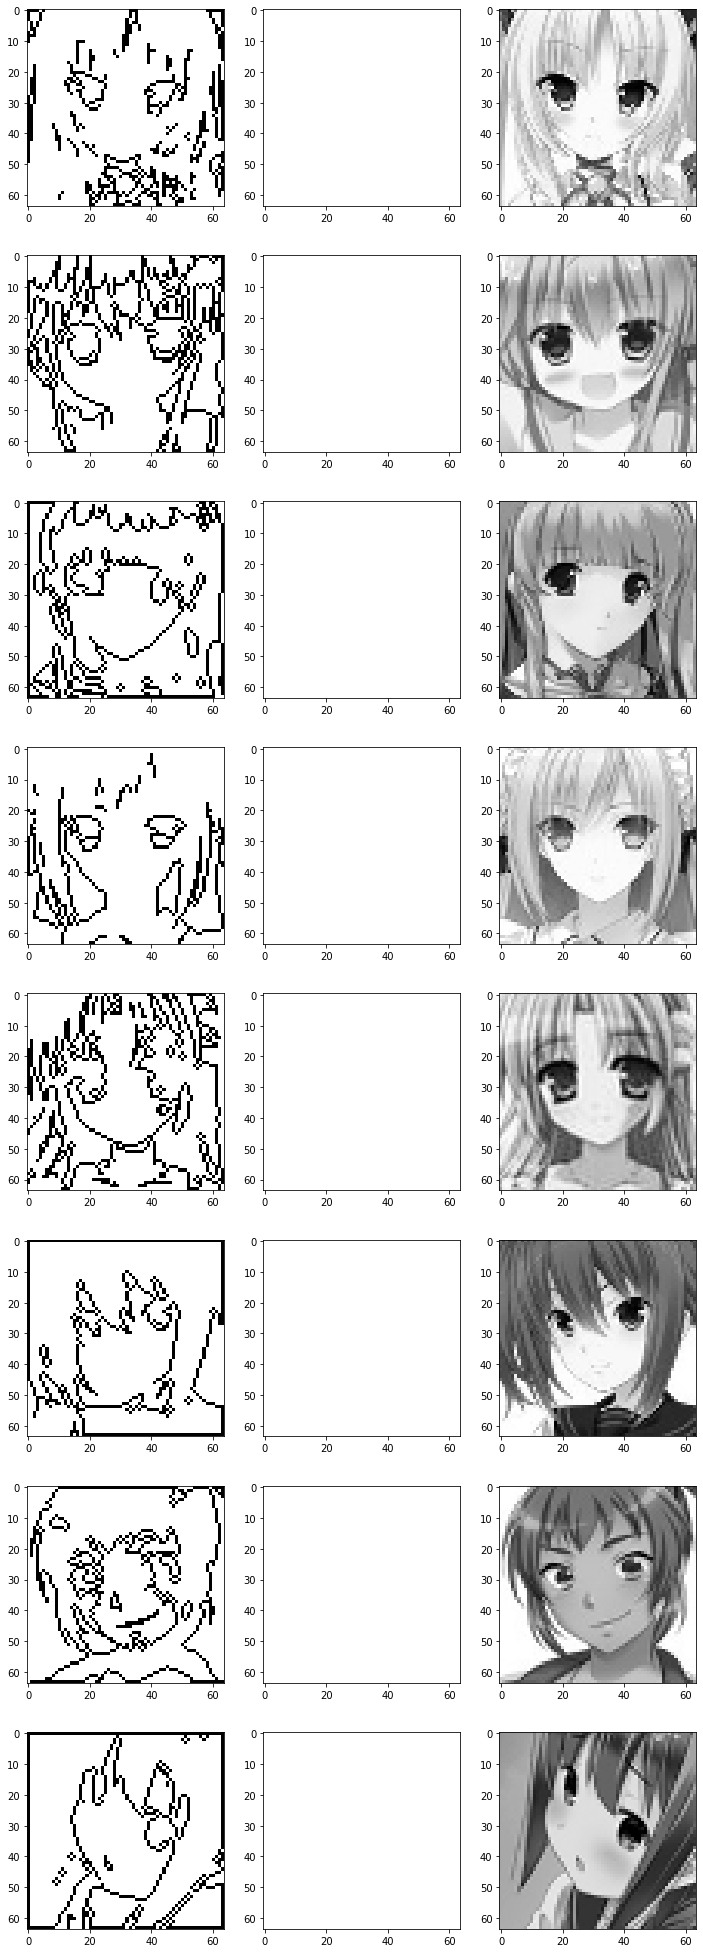

In [19]:
generator.eval()
data_gen = get_generator()
X, y = next(data_gen)

example_imgs = []

for i in range(batch_size):
    outline = X[i].squeeze().detach().numpy()
    img = generator(X[i:i+1]).squeeze().detach().numpy()
    actual = y[i].squeeze().detach().numpy()
    
    example_imgs.append(outline)
    example_imgs.append(img)
    example_imgs.append(actual)

plt.figure(figsize=(12, batch_size * 5))
columns = 3
for i, img in enumerate(example_imgs):
    plt.subplot(len(example_imgs) / columns + 1, columns, i + 1)
    plt.imshow(img, cmap='gray')